# Práctico librería implicit - ALS y BPR


[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1afzSaU23AIP9ZA2NDXCGNWTwf-gsaCg0?usp=sharing)


Clase: IIC3633 Sistemas Recomendadores, PUC Chile

En este práctico vamos a utilizar la biblioteca de Python [implicit](https://implicit.readthedocs.io/en/latest/quickstart.html) para recomendación utilizando ALS y BPR. 


In [6]:
!curl -L -o "u2.base" "https://drive.google.com/uc?export=download&id=1bGweNw7NbOHoJz11v6ld7ymLR8MLvBsA"
!curl -L -o "u2.test" "https://drive.google.com/uc?export=download&id=1f_HwJWC_1HFzgAjKAWKwkuxgjkhkXrVg"
!curl -L -o "u.item" "https://drive.google.com/uc?export=download&id=10YLhxkO2-M_flQtyo9OYV4nT9IvSESuz"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   388    0   388    0     0    746      0 --:--:-- --:--:-- --:--:--   744
100 1546k  100 1546k    0     0  2261k      0 --:--:-- --:--:-- --:--:-- 2261k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   388    0   388    0     0   1208      0 --:--:-- --:--:-- --:--:--  1208
100  385k  100  385k    0     0   677k      0 --:--:-- --:--:-- --:--:--  677k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   388    0   388    0     0   1251      0 --:--:-- --:--:-- --:--:--  1251
100  230k  100  230k    0     0   348k      0 --:--:-- --:--:-- --:--:--  348k


In [7]:
!pip3 install implicit --upgrade

  Using cached https://files.pythonhosted.org/packages/5a/d8/6b4f1374ffa2647b72ac76960c71b984c6f3238090359fb419d03827d87a/implicit-0.4.2.tar.gz
  Created wheel for implicit: filename=implicit-0.4.2-cp36-cp36m-linux_x86_64.whl size=3420106 sha256=db75961449af15d46bb703276ca717880902be15878f34506e195a464e3ad922
  Stored in directory: /root/.cache/pip/wheels/1b/48/b1/1aebe3acc3afb5589e72d3e7c3ffc3f637dc4721c1a974dff7
Successfully built implicit


In [21]:
import pandas as pd
import numpy as np
import implicit
import scipy.sparse as sparse

In [22]:
columns = ['movieid', 'title', 'release_date', 'video_release_date', \
           'IMDb_URL', 'unknown', 'Action', 'Adventure', 'Animation', \
           'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', \
           'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', \
           'Thriller', 'War', 'Western']

In [23]:
# Primero creamos el dataframe con los datos
df_train = pd.read_csv('u2.base',
                         sep='\t',
                         names=['userid', 'itemid', 'rating', 'timestamp'],
                         header=None)

# rating >= 3 , relevante (1) y rating menor a 3 es no relevante (0)
df_train.rating = [1 if x >=3 else 0 for x in df_train.rating ]

In [24]:
df_train.head()

,userid,itemid,rating,timestamp
0,1,3,1,878542960
1,1,4,1,876893119
2,1,5,1,889751712
3,1,6,1,887431973
4,1,7,1,875071561


In [25]:
# Cargamos el dataset con los items
df_items = pd.read_csv('u.item',
                        sep='|',
                        index_col=0,
                        names = columns,
                        header=None, 
                        encoding='latin-1')

In [26]:
df_items.head()

,title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movieid,,,,,,,,,,,,,,,,,,,,,,,
1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0


In [27]:
# Cargamos el dataset de testing
df_test = pd.read_csv('u2.test',
                      sep='\t',
                      names=['userid', 'itemid', 'rating', 'timestamp'],
                      header=None)


# rating >= 3 es relevante (1) y rating menor a 3 es no relevante (0) 
df_test.rating = [1 if x >=3 else 0 for x in df_test.rating ]


user_items_test = {}

for row in df_test.itertuples():
    if row[1] not in user_items_test:
        user_items_test[row[1]] = []
        
    user_items_test[row[1]].append(row[2])

In [28]:
df_test.head()

,userid,itemid,rating,timestamp
0,1,1,1,874965758
1,1,2,1,876893171
2,1,8,0,875072484
3,1,9,1,878543541
4,1,21,0,878542772


In [29]:
df_test.loc[1026]

userid              36
itemid             873
rating               1
timestamp    882157386
Name: 1026, dtype: int64

### Métricas

In [30]:
# Definicion de métricas (No editar)
# Obtenido de https://gist.github.com/bwhite/3726239

def precision_at_k(r, k):
    assert k >= 1
    r = np.asarray(r)[:k] != 0
    if r.size != k:
        raise ValueError('Relevance score length < k')
    return np.mean(r)

def average_precision(r):
    r = np.asarray(r) != 0
    out = [precision_at_k(r, k + 1) for k in range(r.size) if r[k]]
    if not out:
        return 0.
    return np.mean(out)

def mean_average_precision(rs):
    return np.mean([average_precision(r) for r in rs])
  
def dcg_at_k(r, k):
    r = np.asfarray(r)[:k]
    if r.size:
        return np.sum(np.subtract(np.power(2, r), 1) / np.log2(np.arange(2, r.size + 2)))
    return 0.


def ndcg_at_k(r, k):
    idcg = dcg_at_k(sorted(r, reverse=True), k)

    if not idcg:
        return 0.
    return dcg_at_k(r, k) / idcg

### Preprocesamiento de los datos a formato sparse

In [31]:
user_items = {}
itemset = set()

for row in df_train.itertuples():
    if row[1] not in user_items:
        user_items[row[1]] = []
        
    user_items[row[1]].append(row[2])
    itemset.add(row[2])

itemset = np.sort(list(itemset))

sparse_matrix = np.zeros((len(user_items), len(itemset)))

for i, items in enumerate(user_items.values()):
    sparse_matrix[i] = np.isin(itemset, items, assume_unique=True).astype(int)
    
matrix = sparse.csr_matrix(sparse_matrix.T)

user_ids = {key: i for i, key in enumerate(user_items.keys())}
user_item_matrix = matrix.T.tocsr()

In [32]:
def evaluate_model(model, n):
  mean_map = 0.
  mean_ndcg = 0.
  # print(user_items_test[77])
  # print([t[0] for t in model.recommend(77, user_item_matrix, n)])
  for u in user_items_test.keys():
    rec = [t[0] for t in model.recommend(u, user_item_matrix, n)]
    rel_vector = [np.isin(user_items_test[u], rec, assume_unique=True).astype(int)]
    mean_map += mean_average_precision(rel_vector)
    mean_ndcg += ndcg_at_k(rel_vector, n)

  mean_map /= len(user_items_test)
  mean_ndcg /= len(user_items_test)
  
  return mean_map, mean_ndcg

In [33]:
def show_recommendations(model, user, n):
  recommendations = [t[0] for t in model.recommend(user, user_item_matrix, n)]
  return df_items.loc[recommendations]['title']

In [34]:
def show_similar_movies(model, item, n=10):
  sim_items = [t[0] for t in model.similar_items(item, n)]
  return df_items.loc[sim_items]['title']

## ALS (Implicit Feedback)

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(style="whitegrid")

**Pregunta 1:** Explique brevemente cómo funciona el algoritmo ALS.

**Respuesta:** Básicamente, transforma la matriz usuario item a una matriz de usuario con factores latentes y a una de items con factores latentes. Así, primero busca la matriz de items minimizando una función objetivo y luego, manteniendo esto, busca la de usuario con la técnica de gradiente estocástico.

In [36]:
# Definimos y entrenamos el modelo con optimización ALS
model_als = implicit.als.AlternatingLeastSquares(factors=100, iterations=10, use_gpu=False)
model_als.fit(matrix)

Ejemplo de recomendación y búsqueda de items similares con los factores latentes ya entrenados:

In [37]:
show_recommendations(model_als, user=77, n=10)

movieid
257                                  Men in Black (1997)
292                                      Rosewood (1997)
256    When the Cats Away (Chacun cherche son chat) (...
258                                       Contact (1997)
754                                    Red Corner (1997)
273                                          Heat (1995)
125                                    Phenomenon (1996)
409                                          Jack (1996)
864                           My Fellow Americans (1996)
357               One Flew Over the Cuckoo's Nest (1975)
Name: title, dtype: object

In [38]:
rec = [t[0] for t in model_als.recommend(77, user_item_matrix, 10)]
rec

[257, 292, 256, 258, 754, 273, 125, 409, 864, 357]

In [39]:
maprec, ndcg = evaluate_model(model_als, n=10)
print('map: {}\nndcg: {}'.format(maprec, ndcg))
# df_test.loc[[258, 256, 273, 257, 299, 292, 754, 409, 320, 1026]]["itemid"].to_list()

map: 0.06587709088959647
ndcg: 0.33843797856049007


**Pregunta 2:** Pruebe distintos valores para los parámetros de ALS y muestre gráficos de cómo se ven afectadas las métricas recién mostradas.

In [40]:
maprecs = []
ndcgs = []
por = 0
for it in [50, 100, 200]:
  for fa in [50, 100, 200, 400]:
    # Definimos y entrenamos el modelo con optimización ALS
    model_als = implicit.als.AlternatingLeastSquares(factors=fa, iterations=it, use_gpu=False)
    model_als.fit(matrix)
    maprec, ndcg = evaluate_model(model_als, n=10)
    maprecs.append(maprec)
    ndcgs.append(ndcg)
    por += 100/12
    print(por, "%", fa, it)


8.333333333333334 % 50 50



16.666666666666668 % 100 50



25.0 % 200 50



33.333333333333336 % 400 50



41.66666666666667 % 50 100



50.00000000000001 % 100 100



58.33333333333334 % 200 100



66.66666666666667 % 400 100



75.0 % 50 200



83.33333333333333 % 100 200



91.66666666666666 % 200 200



99.99999999999999 % 400 200


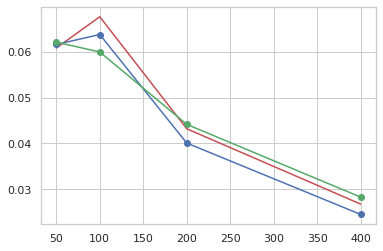

In [41]:
# MAPREC
plt.plot([50, 100, 200, 400], maprecs[:4], 'r-', label = "50 factores")
plt.plot([50, 100, 200, 400], maprecs[4:8], 'bo-', label = "100 factores")
plt.plot([50, 100, 200, 400], maprecs[8:], 'go-', label = "200 factores")
plt.show()

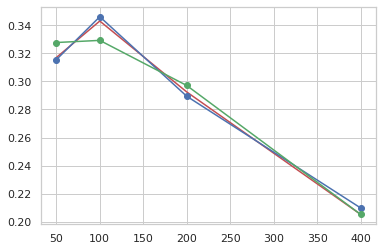

In [46]:
# NDCG
plt.plot([50, 100, 200, 400], ndcgs[:4], 'r-', label = "50 factores")
plt.plot([50, 100, 200, 400], ndcgs[4:8], 'bo-', label = "100 factores")
plt.plot([50, 100, 200, 400], ndcgs[8:], 'go-', label = "200 factores")
plt.show()

## BPR

**Pregunta 3:** Explique con sus palabras la intuición del framework BPR.
**Respuesta:** Dado un usuario y una lista de items el usuario podría ordenarlas según su preferencia. Según ruij. Ejemplo. Rui = 4. Ruj =1. Ruij = 3. Ruji = -3 (ejemplo súper básico). De esta manera, para cada usuario se genera una matriz de preferencia entre items con valores positivos, negativos y nulos (que referencian a desconocido).
Así, en lugar de predecir una calificación precisa para cada elemento, solo tenemos que predecir las preferencias relativas del usuario para todos los pares (i, j).

Por tanto, se maximiza el número de predicciones correctas de todos los pares (i, j), lo que equivale a maximizar el AUC, el área bajo la curva ROC. Y así se obtiene una matriz I para cada usuario.

In [42]:
# Definimos y entrenamos el modelo de implicit feedback utilizando optimizacion BPR
model_bpr = implicit.bpr.BayesianPersonalizedRanking(factors=400, iterations=40, use_gpu=False)
model_bpr.fit(matrix)

Ejemplo de recomendación y búsqueda de items similares con los factores latentes ya entrenados:

In [43]:
show_recommendations(model_bpr, user=77, n=10)

movieid
257              Men in Black (1997)
746               Real Genius (1985)
332            Kiss the Girls (1997)
285            Secrets & Lies (1996)
244    Smilla's Sense of Snow (1997)
327                  Cop Land (1997)
299                   Hoodlum (1997)
325                     Crash (1996)
267                          unknown
331                 Edge, The (1997)
Name: title, dtype: object

In [44]:
show_similar_movies(model_bpr, item=171, n=10)

movieid
171                Delicatessen (1991)
209          This Is Spinal Tap (1984)
203                  Unforgiven (1992)
78                   Free Willy (1993)
27                     Bad Boys (1995)
172    Empire Strikes Back, The (1980)
68                    Crow, The (1994)
173         Princess Bride, The (1987)
167            Private Benjamin (1980)
194                  Sting, The (1973)
Name: title, dtype: object

In [45]:
maprec, ndcg = evaluate_model(model_bpr, n=10)
print('map: {}\nndcg: {}'.format(maprec, ndcg))

map: 0.05274191971270205
ndcg: 0.33843797856049007


**Pregunta 4:** Pruebe distintos valores para los parámetros de BPR y muestre gráficos de cómo se ven afectadas las métricas de ranking (nDCG@10 y MAP) recién mostradas.

In [47]:
maprecs = []
ndcgs = []
por = 0
for it in [50, 100, 200]:
  for fa in [50, 100, 200, 400]:
    # Definimos y entrenamos el modelo con optimización ALS
    model_bpr = implicit.bpr.BayesianPersonalizedRanking(factors=fa, iterations=it, use_gpu=False)
    model_bpr.fit(matrix)
    maprec, ndcg = evaluate_model(model_bpr, n=10)
    maprecs.append(maprec)
    ndcgs.append(ndcg)
    por += 100/12
    print(por, "%", fa, it)


8.333333333333334 % 50 50



16.666666666666668 % 100 50



25.0 % 200 50



33.333333333333336 % 400 50



41.66666666666667 % 50 100



50.00000000000001 % 100 100



58.33333333333334 % 200 100



66.66666666666667 % 400 100



75.0 % 50 200



83.33333333333333 % 100 200



91.66666666666666 % 200 200



99.99999999999999 % 400 200


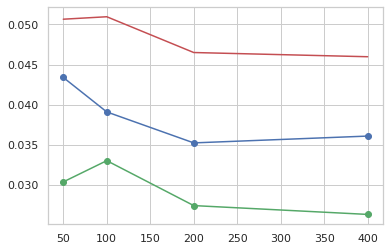

In [48]:
# MAPREC
plt.plot([50, 100, 200, 400], maprecs[:4], 'r-', label = "50 factores")
plt.plot([50, 100, 200, 400], maprecs[4:8], 'bo-', label = "100 factores")
plt.plot([50, 100, 200, 400], maprecs[8:], 'go-', label = "200 factores")
plt.show()

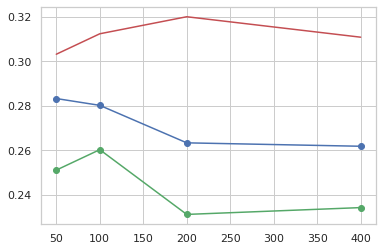

In [49]:
# NDCG
plt.plot([50, 100, 200, 400], ndcgs[:4], 'r-', label = "50 factores")
plt.plot([50, 100, 200, 400], ndcgs[4:8], 'bo-', label = "100 factores")
plt.plot([50, 100, 200, 400], ndcgs[8:], 'go-', label = "200 factores")
plt.show()